In [4]:
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt

# Function to remove outliers further than 2 std deviations from the mean
def filter_outliers(df):
    mean_rt = df['Reaction Time (s)'].mean()
    std_rt = df['Reaction Time (s)'].std()
    return df[(df['Reaction Time (s)'] >= mean_rt - 2 * std_rt) & (df['Reaction Time (s)'] <= mean_rt + 2 * std_rt)]


# Human Data & Statistics

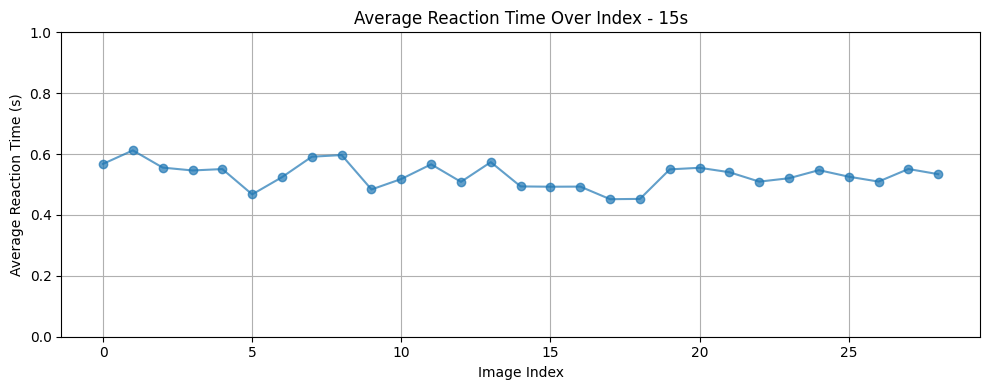

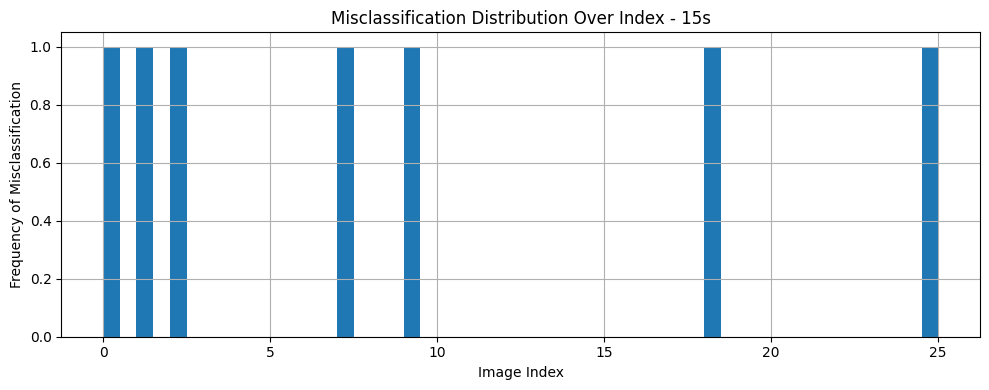

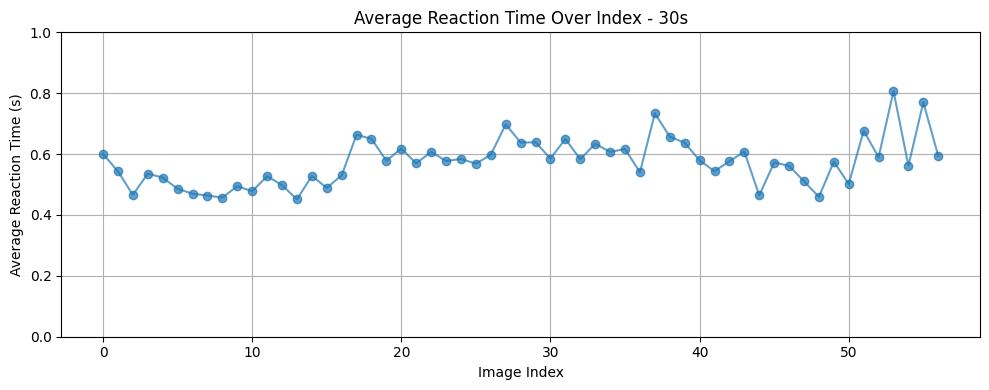

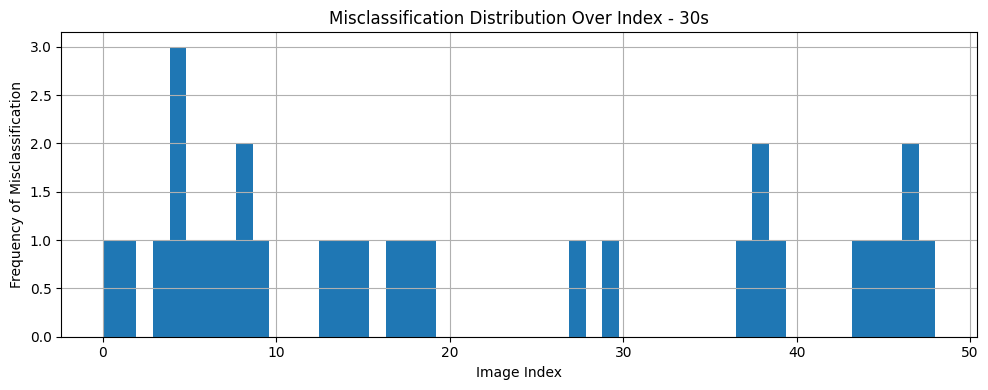

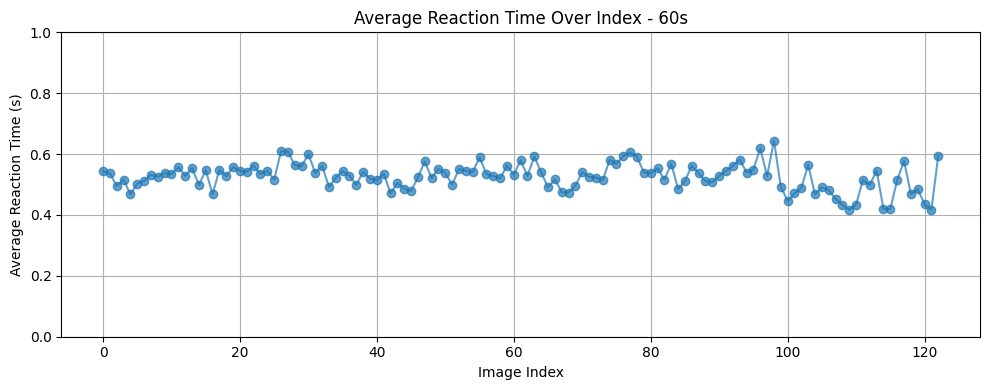

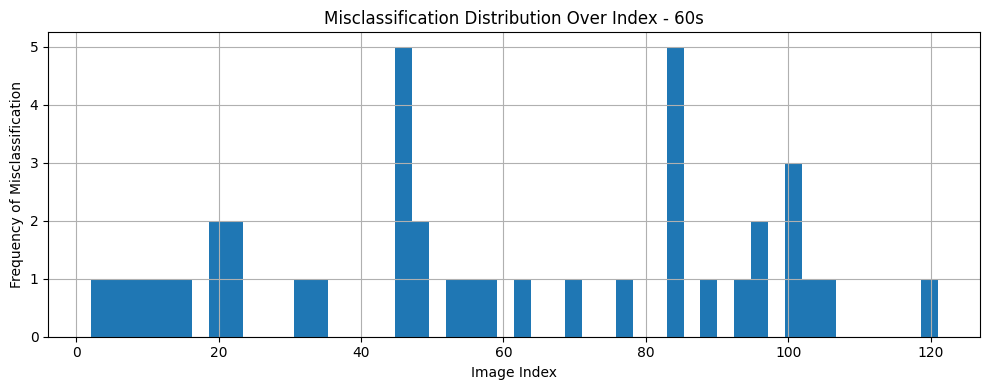

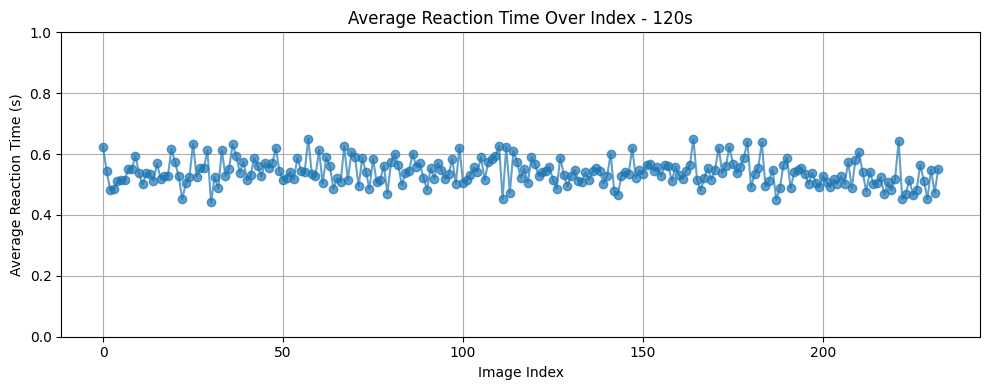

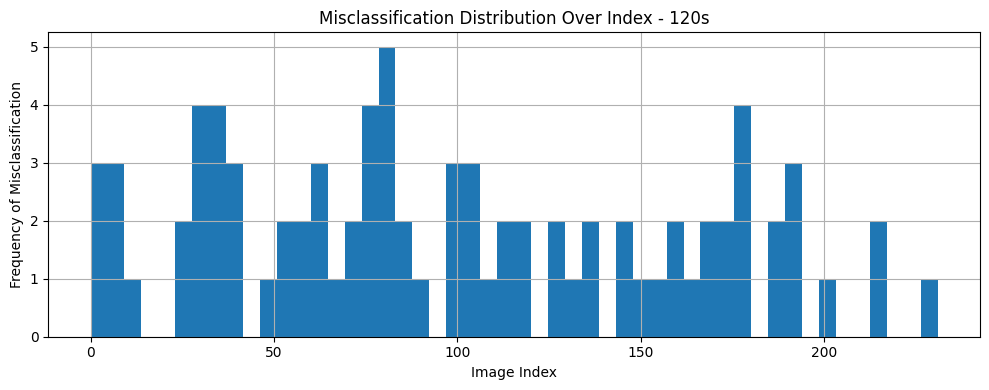

Duration: 15 seconds
  Average Reaction Time: 0.53 s
  Accuracy: 94.66%

Duration: 30 seconds
  Average Reaction Time: 0.569 s
  Accuracy: 87.76%

Duration: 60 seconds
  Average Reaction Time: 0.533 s
  Accuracy: 92.42%

Duration: 120 seconds
  Average Reaction Time: 0.543 s
  Accuracy: 92.1%

Total Average Reaction Time: 0.543 s
Total Accuracy: 91.82%


In [5]:
# Durations to look for
durations = ['15', '30', '60', '120']

# Number of sections to divide each run into
num_sections = 12

# Results will be stored here
results = {}

# Loop through each duration
for duration in durations:
    # Find matching files
    files = glob.glob(f'data/{duration}*.csv')

    all_data = []
    misclass_by_section = []  # To collect per-section misclassifications

    for file in files:
        df = pd.read_csv(file)
        df = filter_outliers(df)
        all_data.append(df)

        # Split into `num_sections` sections
        section_size = len(df) // num_sections
        misclass_counts = []

        for i in range(num_sections):
            start = i * section_size
            # Make sure the last section includes any remaining rows
            end = (i + 1) * section_size if i < num_sections - 1 else len(df)
            section = df.iloc[start:end]
            misclassified = (section['True Label'] != section['User Choice']).sum()
            misclass_counts.append(misclassified)

        misclass_by_section.append(misclass_counts)

    if all_data:
        # Combine all dataframes
        combined = pd.concat(all_data, ignore_index=True)

        # Calculate average reaction time
        avg_time = combined['Reaction Time (s)'].mean()

        # Calculate accuracy
        accuracy = (combined['True Label'] == combined['User Choice']).mean()

        results[duration] = {
            'Average Reaction Time (s)': round(avg_time, 3),
            'Accuracy': round(accuracy * 100, 2)  # as percentage
        }

        # --- Plot average reaction time over index ---
        reaction_times_by_index = {}
        for df in all_data:
            for i, rt in enumerate(df['Reaction Time (s)']):
                reaction_times_by_index.setdefault(i, []).append(rt)
        avg_rt_per_index = [sum(times)/len(times) for i, times in sorted(reaction_times_by_index.items())]

        plt.figure(figsize=(10, 4))
        plt.plot(avg_rt_per_index, marker='o', linestyle='-', alpha=0.7)
        plt.title(f'Average Reaction Time Over Index - {duration}s')
        plt.xlabel('Image Index')
        plt.ylabel('Average Reaction Time (s)')
        plt.ylim(0, 1)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Plot histogram of misclassification distribution over image index ---
        misclassified_indices = []

        for df in all_data:
            misclassified = df[df['True Label'] != df['User Choice']]
            misclassified_indices.extend(misclassified.index.tolist())

        plt.figure(figsize=(10, 4))
        plt.hist(misclassified_indices, bins=50)
        plt.title(f'Misclassification Distribution Over Index - {duration}s')
        plt.xlabel('Image Index')
        plt.ylabel('Frequency of Misclassification')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Display results
total_reaction_time = 0
total_correct = 0
total_count = 0

for duration, stats in results.items():
    print(f"Duration: {duration} seconds")
    print(f"  Average Reaction Time: {stats['Average Reaction Time (s)']} s")
    print(f"  Accuracy: {stats['Accuracy']}%\n")

    # Aggregate for overall stats
    # Convert accuracy percentage back to fraction for proper count estimation
    duration_count = 0
    duration_correct = 0
    for file in glob.glob(f'data/{duration}*.csv'):
        df = pd.read_csv(file)
        df = filter_outliers(df)
        total_reaction_time += df['Reaction Time (s)'].sum()
        duration_count += len(df)
        duration_correct += (df['True Label'] == df['User Choice']).sum()
    total_correct += duration_correct
    total_count += duration_count

# Calculate overall stats
overall_avg_reaction_time = round(total_reaction_time / total_count, 3)
overall_accuracy = round((total_correct / total_count) * 100, 2)

print(f"Total Average Reaction Time: {overall_avg_reaction_time} s")
print(f"Total Accuracy: {overall_accuracy}%")


# AI Data and Statistics CPU vs. GPU

Model: AlexNet_224_GaussBlur (GPU)
  Average Reaction Time: 0.003 s
  Accuracy: 84.38%

Model: AlexNet_224_GaussBlur (CPU)
  Average Reaction Time: 0.018 s
  Accuracy: 84.36%



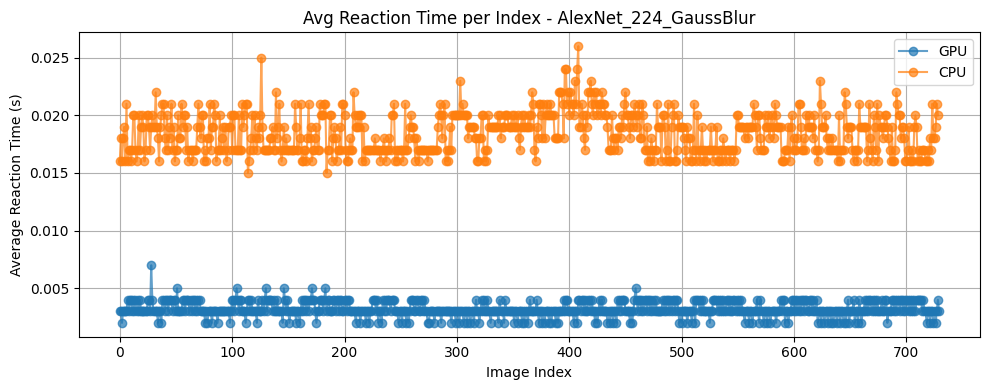

Model: BasicCNN_77 (GPU)
  Average Reaction Time: 0.004 s
  Accuracy: 78.08%

Model: BasicCNN_77 (CPU)
  Average Reaction Time: 0.03 s
  Accuracy: 78.01%



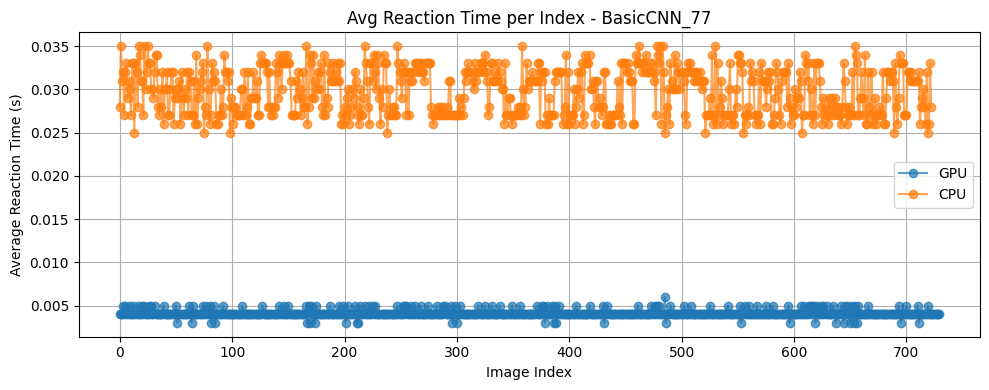

Model: densenet121_noGaussBlur (GPU)
  Average Reaction Time: 0.025 s
  Accuracy: 98.35%

Model: densenet121_noGaussBlur (CPU)
  Average Reaction Time: 0.057 s
  Accuracy: 98.59%



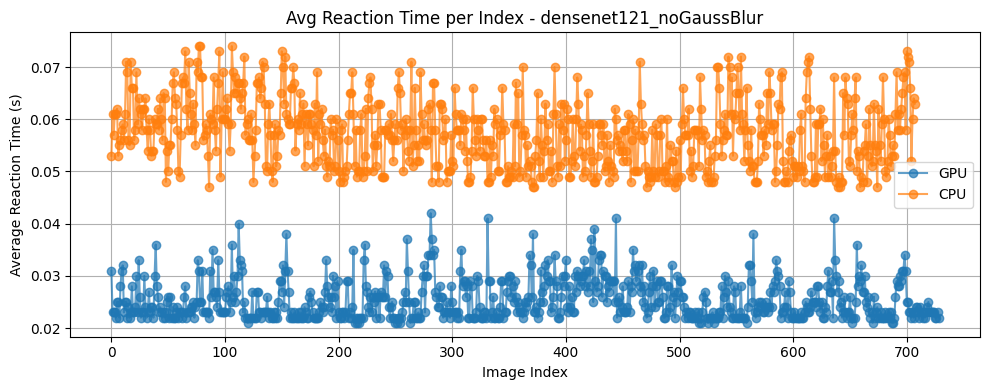

In [6]:
models = [
    'AlexNet_224_GaussBlur_all',
    'AlexNet_224_GaussBlur_CPU',
    'BasicCNN_77_all',
    'BasicCNN_77_CPU',
    'densenet121_noGaussBlur_all',
    'densenet121_noGaussBlur_CPU'
]

# Group models into pairs: GPU vs CPU
model_pairs = {}
for model in models:
    key = model.replace('_CPU', '').replace('_all', '')
    model_pairs.setdefault(key, {'GPU': None, 'CPU': None})
    if '_CPU' in model:
        model_pairs[key]['CPU'] = model
    else:
        model_pairs[key]['GPU'] = model

# Loop through model pairs
for model_name, sources in model_pairs.items():
    fig1, ax1 = plt.subplots(figsize=(10, 4))

    for device, model_prefix in sources.items():
        if not model_prefix:
            continue  # Incomplete pair

        files = glob.glob(f'data/{model_prefix}*.csv')
        all_data = []
        misclass_by_section = []
        avg_reaction_times = []
        accuracies = []

        for file in files:
            df = pd.read_csv(file)
            df = filter_outliers(df)
            all_data.append(df)

            # Calculate average reaction time and accuracy
            avg_time = df['Reaction Time (s)'].mean()
            accuracy = (df['True Label'] == df['User Choice']).mean()

            avg_reaction_times.append(avg_time)
            accuracies.append(accuracy)

            # Split into sections for misclassification calculation
            section_size = len(df) // num_sections
            misclass_counts = []
            for i in range(num_sections):
                start = i * section_size
                end = (i + 1) * section_size if i < num_sections - 1 else len(df)
                section = df.iloc[start:end]
                misclassified = (section['True Label'] != section['User Choice']).sum()
                misclass_counts.append(misclassified)
            misclass_by_section.append(misclass_counts)

        # Plot reaction time per index
        reaction_times_by_index = {}
        for df in all_data:
            for i, rt in enumerate(df['Reaction Time (s)']):
                reaction_times_by_index.setdefault(i, []).append(rt)
        avg_rt_per_index = [sum(times)/len(times) for i, times in sorted(reaction_times_by_index.items())]

        ax1.plot(avg_rt_per_index, marker='o', linestyle='-', alpha=0.7, label=f'{device}')

        # Print average reaction time and accuracy
        print(f"Model: {model_name} ({device})")
        print(f"  Average Reaction Time: {round(sum(avg_reaction_times)/len(avg_reaction_times), 3)} s")
        print(f"  Accuracy: {round(sum(accuracies)/len(accuracies) * 100, 2)}%")
        print()

    # Final touches: Reaction Time Plot
    ax1.set_title(f'Avg Reaction Time per Index - {model_name}')
    ax1.set_xlabel('Image Index')
    ax1.set_ylabel('Average Reaction Time (s)')
    #ax1.set_ylim(0, 1)
    ax1.grid(True)
    ax1.legend()
    fig1.tight_layout()
    plt.show()

# AI Data and Statistics Model vs. Model

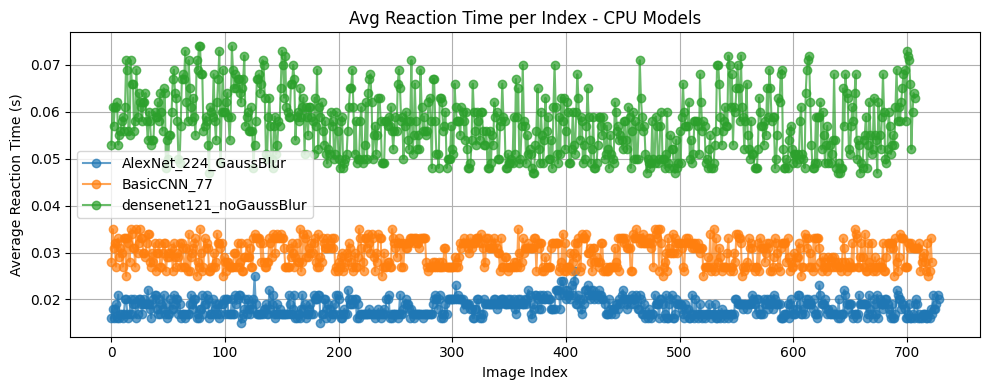

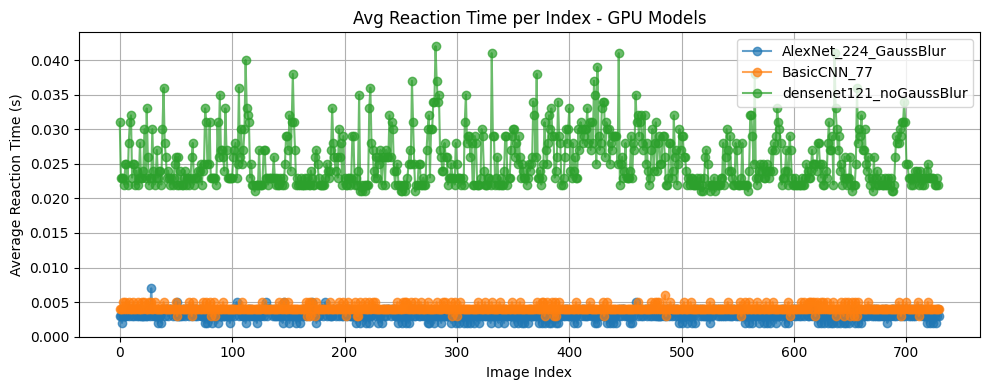

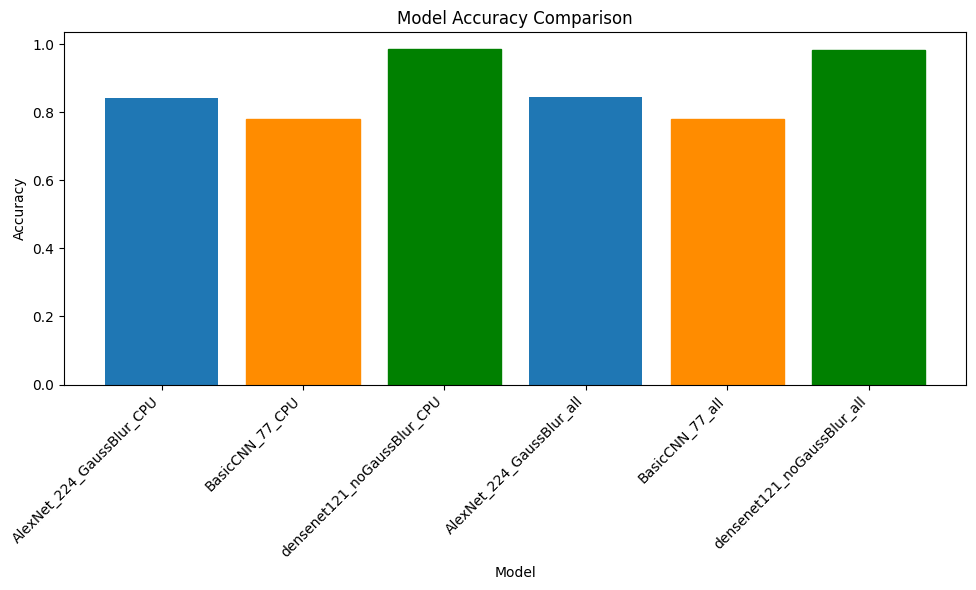

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Assuming 'model_pairs' is predefined
cpu_models = [model_pairs[key]['CPU'] for key in model_pairs if model_pairs[key]['CPU']]
gpu_models = [model_pairs[key]['GPU'] for key in model_pairs if model_pairs[key]['GPU']]

# Function to calculate accuracy
def calculate_accuracy(df):
    return (df['True Label'] == df['User Choice']).mean()

# Plotting CPU models
fig2, ax2 = plt.subplots(figsize=(10, 4))

cpu_accuracies = []

for model_prefix in cpu_models:
    files = glob.glob(f'data/{model_prefix}*.csv')
    all_data = []
    avg_reaction_times = []

    for file in files:
        df = pd.read_csv(file)
        df = filter_outliers(df)  # Remove outliers with reaction time > 0.2
        all_data.append(df)

        # Calculate average reaction time
        avg_time = df['Reaction Time (s)'].mean()
        avg_reaction_times.append(avg_time)

        # Calculate accuracy for CPU models
        accuracy = calculate_accuracy(df)
        cpu_accuracies.append((model_prefix, accuracy))

    # Plot reaction time per index for CPU models
    reaction_times_by_index = {}
    for df in all_data:
        for i, rt in enumerate(df['Reaction Time (s)']):
            reaction_times_by_index.setdefault(i, []).append(rt)
    avg_rt_per_index = [sum(times)/len(times) for i, times in sorted(reaction_times_by_index.items())]

    ax2.plot(avg_rt_per_index, marker='o', linestyle='-', alpha=0.7, label=f'{model_prefix[:-4]}')

# Final touches: Reaction Time Plot for CPU models
ax2.set_title('Avg Reaction Time per Index - CPU Models')
ax2.set_xlabel('Image Index')
ax2.set_ylabel('Average Reaction Time (s)')
ax2.grid(True)
ax2.legend()
fig2.tight_layout()
plt.show()

# Plotting GPU models
fig3, ax3 = plt.subplots(figsize=(10, 4))

gpu_accuracies = []

for model_prefix in gpu_models:
    files = glob.glob(f'data/{model_prefix}*.csv')
    all_data = []
    avg_reaction_times = []

    for file in files:
        df = pd.read_csv(file)
        df = filter_outliers(df)  # Remove outliers with reaction time > 0.2
        all_data.append(df)

        # Calculate average reaction time
        avg_time = df['Reaction Time (s)'].mean()
        avg_reaction_times.append(avg_time)

        # Calculate accuracy for GPU models
        accuracy = calculate_accuracy(df)
        gpu_accuracies.append((model_prefix, accuracy))

    # Plot reaction time per index for GPU models
    reaction_times_by_index = {}
    for df in all_data:
        for i, rt in enumerate(df['Reaction Time (s)']):
            reaction_times_by_index.setdefault(i, []).append(rt)
    avg_rt_per_index = [sum(times)/len(times) for i, times in sorted(reaction_times_by_index.items())]

    ax3.plot(avg_rt_per_index, marker='o', linestyle='-', alpha=0.7, label=f'{model_prefix[:-4]}')

# Final touches: Reaction Time Plot for GPU models
ax3.set_title('Avg Reaction Time per Index - GPU Models')
ax3.set_xlabel('Image Index')
ax3.set_ylabel('Average Reaction Time (s)')
ax3.grid(True)
ax3.legend()
fig3.tight_layout()
plt.show()

# Barplot for accuracy comparison
fig4, ax4 = plt.subplots(figsize=(10, 6))

# Combining both CPU and GPU accuracies
all_accuracies = cpu_accuracies + gpu_accuracies
models, accuracies = zip(*all_accuracies)

# Plotting barplot
bars = ax4.bar(models, accuracies)
ax4.set_title('Model Accuracy Comparison')
ax4.set_xlabel('Model')
ax4.set_ylabel('Accuracy')
ax4.set_xticks(models)
ax4.set_xticklabels(models, rotation=45, ha='right')
bars[1].set_color('darkorange')
bars[2].set_color('green')
bars[4].set_color('darkorange')
bars[5].set_color('green')
fig4.tight_layout()
plt.show()


# AI vs. Human Performance
Since the models are so much faster than human performance, they finish the entire test set before even coming close to the time limit. For this reason, we plot the reaction times from the slowest model (densenet on CPU) against the average 120s human classification.

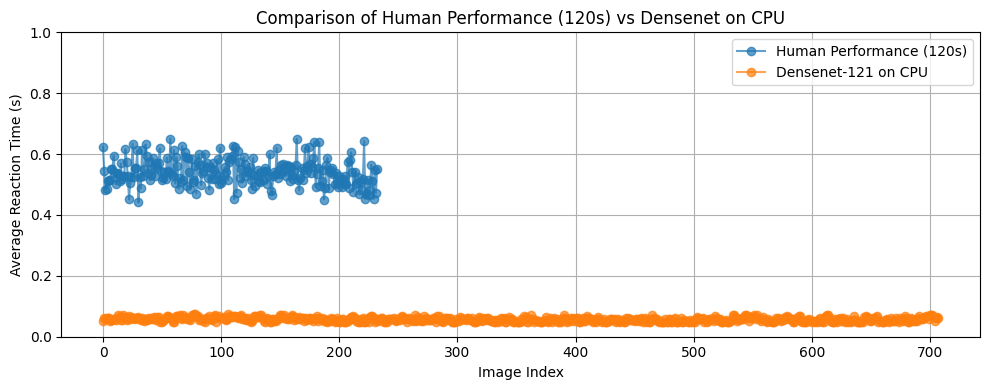

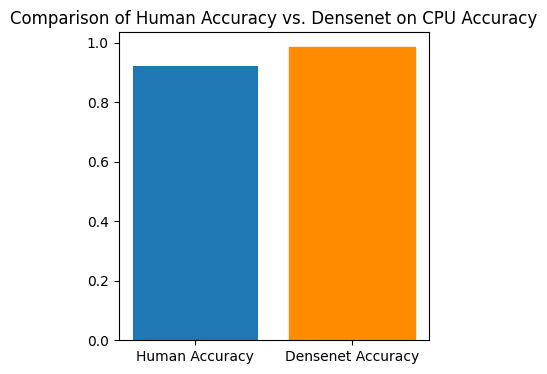

In [9]:
# Load human performance data for the 120s duration
human_120_files = glob.glob(f'data/120*.csv')
human_data = []
for file in human_120_files:
    df = pd.read_csv(file)
    df = filter_outliers(df)  # Remove outliers
    human_data.append(df)

# --- Calculate average reaction time per index for human data ---
reaction_times_by_index_human = {}
for df in human_data:
    for i, rt in enumerate(df['Reaction Time (s)']):
        reaction_times_by_index_human.setdefault(i, []).append(rt)
avg_rt_per_index_human = [sum(times) / len(times) for i, times in sorted(reaction_times_by_index_human.items())]

# Accuracy of humans
combined = pd.concat(human_data, ignore_index=True)
human_accuracy = (combined['True Label'] == combined['User Choice']).mean()

# Load Densenet model on CPU data
densenet_cpu_files = glob.glob(f'data/densenet121_noGaussBlur_CPU*.csv')
densenet_cpu_data = []
for file in densenet_cpu_files:
    df = pd.read_csv(file)
    df = filter_outliers(df)  # Remove outliers
    densenet_cpu_data.append(df)

# --- Calculate average reaction time per index for Densenet CPU data ---
reaction_times_by_index_densenet_cpu = {}
for df in densenet_cpu_data:
    for i, rt in enumerate(df['Reaction Time (s)']):
        reaction_times_by_index_densenet_cpu.setdefault(i, []).append(rt)
avg_rt_per_index_densenet_cpu = [sum(times) / len(times) for i, times in sorted(reaction_times_by_index_densenet_cpu.items())]

# Accuracy of AI
combined = pd.concat(densenet_cpu_data, ignore_index=True)
ai_accuracy = (combined['True Label'] == combined['User Choice']).mean()

# Plot both human performance and Densenet CPU performance
plt.figure(figsize=(10, 4))
plt.plot(avg_rt_per_index_human, label='Human Performance (120s)', marker='o', linestyle='-', alpha=0.7)
plt.plot(avg_rt_per_index_densenet_cpu, label='Densenet-121 on CPU', marker='o', linestyle='-', alpha=0.7)

plt.title('Comparison of Human Performance (120s) vs Densenet on CPU')
plt.xlabel('Image Index')
plt.ylabel('Average Reaction Time (s)')
plt.ylim(0, 1)  # Adjust the y-limit as needed
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Draw bar plot to compare accuracy
fig, ax = plt.subplots(figsize=(4, 4))
bars = ax.bar(('Human Accuracy', 'Densenet Accuracy'), (human_accuracy, ai_accuracy))
ax.set_title("Comparison of Human Accuracy vs. Densenet on CPU Accuracy")
bars[1].set_color('darkorange')
plt.show()

# Llama-Duck vs. Duck-Llama Misclassifications

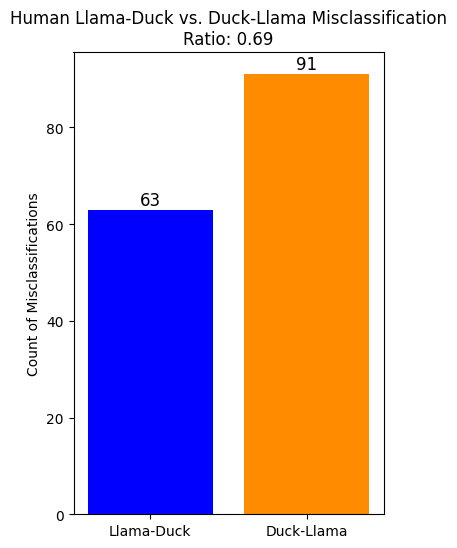

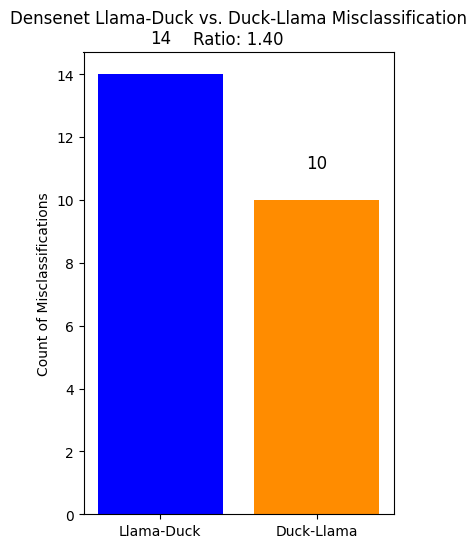

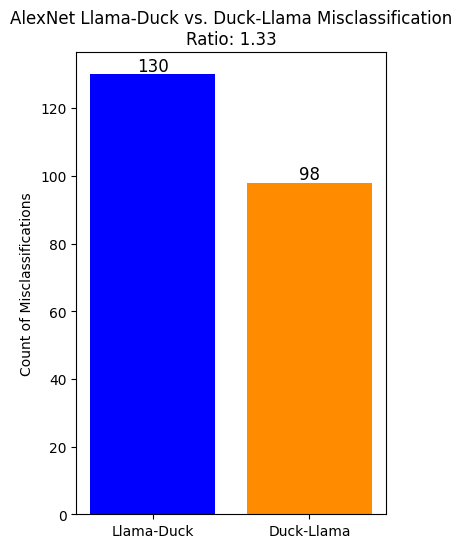

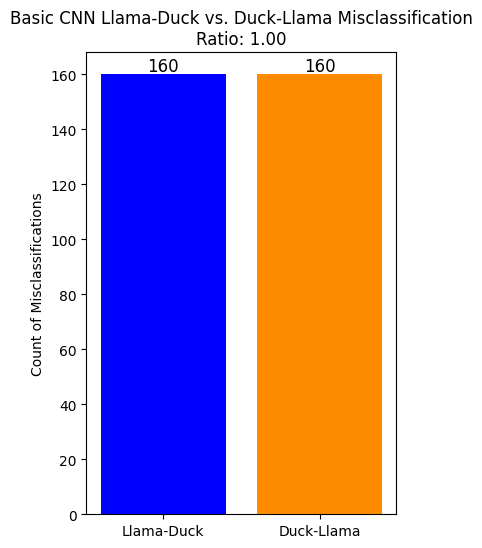

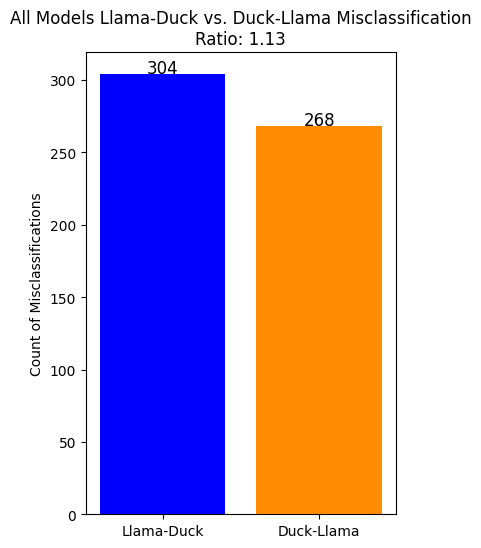

In [10]:

def plot_misclassifications(title, fileregex):
    # List of CSV file paths (replace with your actual file list)
    csv_files = glob.glob(f'{fileregex}')  # Example list of CSV files
    # Initialize counters for misclassifications
    llama_duck_misclassifications = 0
    duck_llama_misclassifications = 0

    # Loop through each CSV file
    for file in csv_files:
        df = pd.read_csv(file)

        # Identify misclassifications where 'llama' is misclassified as 'duck'
        llama_duck_misclassifications += ((df['True Label'] == 'llama') & (df['User Choice'] == 'duck')).sum()

        # Identify misclassifications where 'duck' is misclassified as 'llama'
        duck_llama_misclassifications += ((df['True Label'] == 'duck') & (df['User Choice'] == 'llama')).sum()

    # Calculate the ratio of llama-duck vs. duck-llama misclassifications
    if duck_llama_misclassifications != 0:
        ratio = llama_duck_misclassifications / duck_llama_misclassifications
    else:
        ratio = float('inf')  # To handle division by zero

    # Plotting the ratio
    fig, ax = plt.subplots(figsize=(4, 6))

    # Plot the two types of misclassifications
    ax.bar(['Llama-Duck', 'Duck-Llama'], [llama_duck_misclassifications, duck_llama_misclassifications], color=['blue', 'darkorange'])

    # Adding the ratio as a label above the bars
    ax.text(0, llama_duck_misclassifications + 1, f'{llama_duck_misclassifications}', ha='center', fontsize=12)
    ax.text(1, duck_llama_misclassifications + 1, f'{duck_llama_misclassifications}', ha='center', fontsize=12)

    # Set the title and labels
    ax.set_title(f'{title}\nRatio: {ratio:.2f}')
    ax.set_ylabel('Count of Misclassifications')

    # Show the plot
    plt.show()

# Plot human data
plot_misclassifications('Human Llama-Duck vs. Duck-Llama Misclassification', 'data/[136]*.csv')
plot_misclassifications('Densenet Llama-Duck vs. Duck-Llama Misclassification', 'data/[d]*.csv')
plot_misclassifications('AlexNet Llama-Duck vs. Duck-Llama Misclassification', 'data/[A]*.csv')
plot_misclassifications('Basic CNN Llama-Duck vs. Duck-Llama Misclassification', 'data/[B]*.csv')
plot_misclassifications('All Models Llama-Duck vs. Duck-Llama Misclassification', 'data/[ABd]*.csv')
